In [50]:
import os, sys, random
import numpy as np
import matplotlib.pyplot as plt
import pylab
import matplotlib.animation as animation
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd
import torch.utils.data 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from torchviz import make_dot
from scipy.io import savemat
from funcs2 import * 


number of time steps, ns:  800
number pixels, nps:  128
max no 0.4447629451751709
max T 5192.392578125
max radVar1 78626.9765198
max radVar2 215035.619359
Loaded data, 640 training, 160 validation samples
Loaded data, 640 targets, 160 validation targets
Size of the inputs array: (640, 2, 128, 128)
Size of the targets array: (160, 2, 128, 128)
Size of the vinputs array: (160, 2, 128, 128)
Size of the targets array: (640, 2, 128, 128)


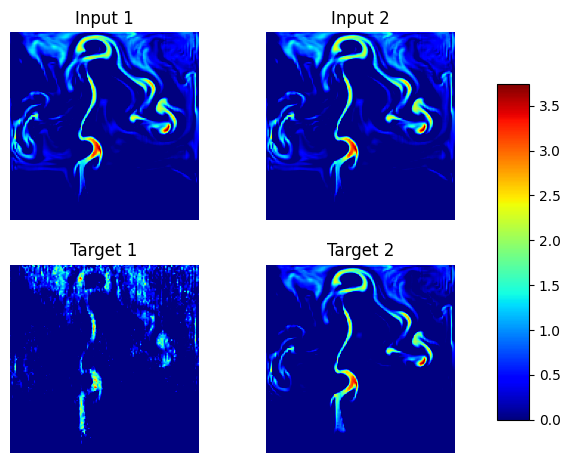

In [51]:
# dataset = 'd300s50/'
# dataset = 'd300s50na/'
dataset = 'd300s200/data_800/'
inputs, targets, zdata = organizedata(dataset,'train/')
ns = len(zdata['no'][:, 0, 0])
nps = len(zdata['no'][0, :, 0])

no_normalizer = UnitGaussianNormalizer(inputs[:,0,:,:])
T_normalizer = UnitGaussianNormalizer(inputs[:,1,:,:])
rad1_normalizer = UnitGaussianNormalizer(targets[:,0,:,:])
rad2_normalizer = UnitGaussianNormalizer(targets[:,1,:,:])

no = no_normalizer.encode(inputs[:,0,:,:])
T = T_normalizer.encode(inputs[:,1,:,:])
rad1 = rad1_normalizer.encode(targets[:,0,:,:])
rad2 = rad2_normalizer.encode(targets[:,1,:,:])

inputs = np.stack([no, T], axis=1)
targets = np.stack([rad1, rad2], axis=1)

X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.20, random_state=42, shuffle=True)

# Assign the training and test sets to new variables
inputs = X_train
targets = y_train
vinputs = X_test
vtargets = y_test

print("Loaded data, {} training, {} validation samples".format(len(inputs),len(vinputs)))
print("Loaded data, {} targets, {} validation targets".format(len(targets),len(vtargets)))
print("Size of the inputs array: "+format(inputs.shape))
print("Size of the targets array: "+format(vtargets.shape))
print("Size of the vinputs array: "+format(vinputs.shape))
print("Size of the targets array: "+format(targets.shape))

showSbs(inputs,targets,3)

In [52]:
# global training constants
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
EPOCHS = 100
BATCH_SIZE = 10
LR = 0.00002

class DfpDataset():
    def __init__(self, inputs,targets): 
        self.inputs  = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

tdata = DfpDataset(inputs,targets)
vdata = DfpDataset(vinputs,vtargets)

trainLoader = torch.utils.data.DataLoader(tdata, batch_size=BATCH_SIZE, shuffle=True , drop_last=True) 
valiLoader  = torch.utils.data.DataLoader(vdata, batch_size=BATCH_SIZE, shuffle=False, drop_last=True) 

print("Training & validation batches: {} , {}".format(len(trainLoader),len(valiLoader) ))

def blockUNet(in_c, out_c, name, size=4, pad=1, transposed=False, bn=True, activation=True, relu=True, dropout=0. ):
    block = nn.Sequential()

    if not transposed:
        block.add_module('%s_conv' % name, nn.Conv2d(in_c, out_c, kernel_size=size, stride=2, padding=pad, bias=True))
    else:
        block.add_module('%s_upsam' % name, nn.Upsample(scale_factor=2, mode='bilinear'))
        # reduce kernel size by one for the upsampling (ie decoder part)
        block.add_module('%s_tconv' % name, nn.Conv2d(in_c, out_c, kernel_size=(size-1), stride=1, padding=pad, bias=True))

    if bn:
        block.add_module('%s_bn' % name, nn.BatchNorm2d(out_c))
    if dropout>0.:
        block.add_module('%s_dropout' % name, nn.Dropout2d( dropout, inplace=True))

    if activation:
        if relu:
            block.add_module('%s_relu' % name, nn.ReLU(inplace=True))
        else:
            block.add_module('%s_leakyrelu' % name, nn.LeakyReLU(0.2, inplace=True))

    return block
    
class DfpNet(nn.Module):
    def __init__(self, channelExponent=6, dropout=0.):
        super(DfpNet, self).__init__()
        channels = int(2 ** channelExponent + 0.5)
        InNum = 2
        self.layer1 = blockUNet(InNum     , channels*1, 'enc_layer1', transposed=False, bn=True, relu=False, dropout=dropout )
        self.layer2 = blockUNet(channels  , channels*2, 'enc_layer2', transposed=False, bn=True, relu=False, dropout=dropout )
        self.layer3 = blockUNet(channels*2, channels*2, 'enc_layer3', transposed=False, bn=True, relu=False, dropout=dropout )
        self.layer4 = blockUNet(channels*2, channels*4, 'enc_layer4', transposed=False, bn=True, relu=False, dropout=dropout )
        self.layer5 = blockUNet(channels*4, channels*8, 'enc_layer5', transposed=False, bn=True, relu=False, dropout=dropout ) 
        self.layer6 = blockUNet(channels*8, channels*8, 'enc_layer6', transposed=False, bn=True, relu=False, dropout=dropout , size=2,pad=0)
        self.layer7 = blockUNet(channels*8, channels*8, 'enc_layer7', transposed=False, bn=True, relu=False, dropout=dropout , size=2,pad=0)
     
        # note, kernel size is internally reduced by one for the decoder part
        self.dlayer7 = blockUNet(channels*8, channels*8, 'dec_layer7', transposed=True, bn=True, relu=True, dropout=dropout , size=2,pad=0)
        self.dlayer6 = blockUNet(channels*16,channels*8, 'dec_layer6', transposed=True, bn=True, relu=True, dropout=dropout , size=2,pad=0)
        self.dlayer5 = blockUNet(channels*16,channels*4, 'dec_layer5', transposed=True, bn=True, relu=True, dropout=dropout ) 
        self.dlayer4 = blockUNet(channels*8, channels*2, 'dec_layer4', transposed=True, bn=True, relu=True, dropout=dropout )
        self.dlayer3 = blockUNet(channels*4, channels*2, 'dec_layer3', transposed=True, bn=True, relu=True, dropout=dropout )
        self.dlayer2 = blockUNet(channels*4, channels  , 'dec_layer2', transposed=True, bn=True, relu=True, dropout=dropout )
        self.dlayer1 = blockUNet(channels*2, InNum     , 'dec_layer1', transposed=True, bn=False, activation=False, dropout=dropout )

    def forward(self, x):
        # note, this Unet stack could be allocated with a loop, of course... 
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        out5 = self.layer5(out4)
        out6 = self.layer6(out5)
        out7 = self.layer7(out6)
        # ... bottleneck ...
        dout6 = self.dlayer7(out7)
        dout6_out6 = torch.cat([dout6, out6], 1)
        dout6 = self.dlayer6(dout6_out6)
        dout6_out5 = torch.cat([dout6, out5], 1)
        dout5 = self.dlayer5(dout6_out5)
        dout5_out4 = torch.cat([dout5, out4], 1)
        dout4 = self.dlayer4(dout5_out4)
        dout4_out3 = torch.cat([dout4, out3], 1)
        dout3 = self.dlayer3(dout4_out3)
        dout3_out2 = torch.cat([dout3, out2], 1)
        dout2 = self.dlayer2(dout3_out2)
        dout2_out1 = torch.cat([dout2, out1], 1)
        dout1 = self.dlayer1(dout2_out1)
        return dout1

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
# channel exponent to control network size
EXPO = 2

# setup network
net = DfpNet(channelExponent=EXPO).to(device)
nn_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in nn_parameters])

print("Trainable params: {}  ".format(params))

net.apply(weights_init)
criterionL1 = nn.L1Loss()
optimizerG = optim.Adam(net.parameters(), lr=LR, betas=(0.5, 0.999), weight_decay=0.0)

targets = torch.autograd.Variable(torch.FloatTensor(BATCH_SIZE, 2, 128, 128)).to(device)
inputs  = torch.autograd.Variable(torch.FloatTensor(BATCH_SIZE, 2, 128, 128)).to(device)

history_L1 = []
history_L1val = []

if os.path.isfile(dataset+'networkk'):
  print("Found existing network, loading & skipping training")
  net.load_state_dict(torch.load(dataset+'network')) # optionally, load existing network

else:
  print("Training from scratch")
  for epoch in range(EPOCHS):
      net.train()
      L1_accum = 0.0
      for i, traindata in enumerate(trainLoader, 0):
          inputs_curr, targets_curr = traindata
          inputs.data.copy_(inputs_curr.float())
          targets.data.copy_(targets_curr.float())

          net.zero_grad()
          gen_out = net(inputs)

          lossL1 = criterionL1(gen_out, targets)
          lossL1.backward()
          optimizerG.step()
          L1_accum += lossL1.item()

      # validation
      net.eval()
      L1val_accum = 0.0
      for i, validata in enumerate(valiLoader, 0):
          inputs_curr, targets_curr = validata
          inputs.data.copy_(inputs_curr.float())
          targets.data.copy_(targets_curr.float())

          outputs = net(inputs)
          outputs_curr = outputs.data.cpu().numpy()

          lossL1val = criterionL1(outputs, targets)
          L1val_accum += lossL1val.item()

      # data for graph plotting
      history_L1.append( L1_accum / len(trainLoader) )
      history_L1val.append( L1val_accum / len(valiLoader) )

      if epoch<3 or epoch%20==0:
          print( "Epoch: {}, L1 train: {:7.5f}, L1 vali: {:7.5f}".format(epoch, history_L1[-1], history_L1val[-1]) )

  torch.save(net.state_dict(), dataset+'network' )
  print("Training done, saved network")

Training & validation batches: 64 , 16
Trainable params: 37258  
Training from scratch
Epoch: 0, L1 train: 0.75558, L1 vali: 0.73432
Epoch: 1, L1 train: 0.70053, L1 vali: 0.67492
Epoch: 2, L1 train: 0.65086, L1 vali: 0.60793
Epoch: 20, L1 train: 0.32935, L1 vali: 0.26392
Epoch: 40, L1 train: 0.27383, L1 vali: 0.24280
Epoch: 60, L1 train: 0.28322, L1 vali: 0.23223
Epoch: 80, L1 train: 0.25410, L1 vali: 0.23212
Training done, saved network


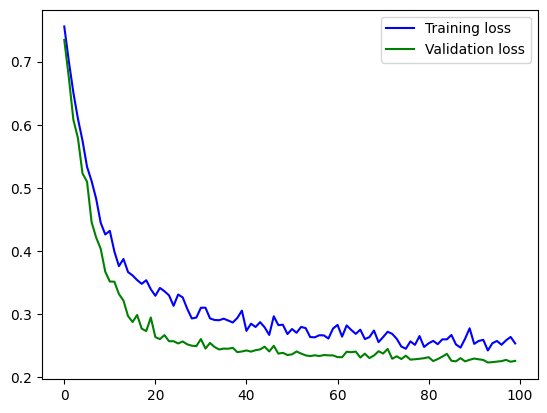

In [53]:

l1train = np.asarray(history_L1)
l1vali  = np.asarray(history_L1val)

plt.plot(np.arange(l1train.shape[0]),l1train,'b',label='Training loss')
plt.plot(np.arange(l1vali.shape[0] ),l1vali ,'g',label='Validation loss')
plt.legend()
plt.show()

In [54]:
net.eval()
for i, validata in enumerate(valiLoader, 0):
    inputs_curr, targets_curr = validata
    inputs.data.copy_(inputs_curr.float())
    targets.data.copy_(targets_curr.float())
    
    outputs = net(inputs)
    outputs_curr = outputs.data.cpu().numpy()
    #if i<1: showSbs(targets_curr , outputs_curr,i)

number of time steps, ns:  800
number pixels, nps:  128
max no 0.2845492959022522
max T 3430.042236328125
max radVar1 39356.4119452
max radVar2 215035.601538
mean/stddev 1399.644204723181 2223.190728547392
mean/stddev 6285.772582114341 14185.468177298439

Average test error: 0.29749730933457613


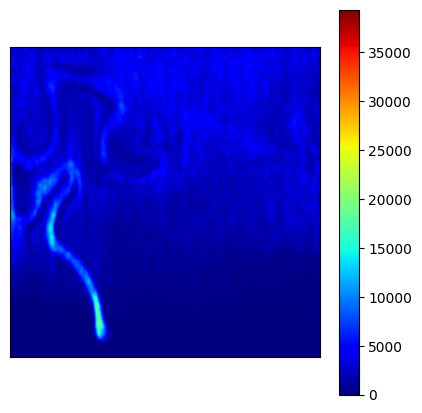

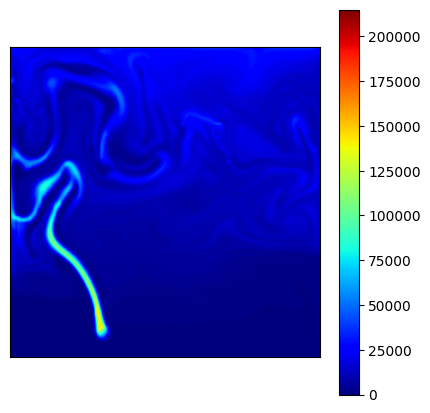

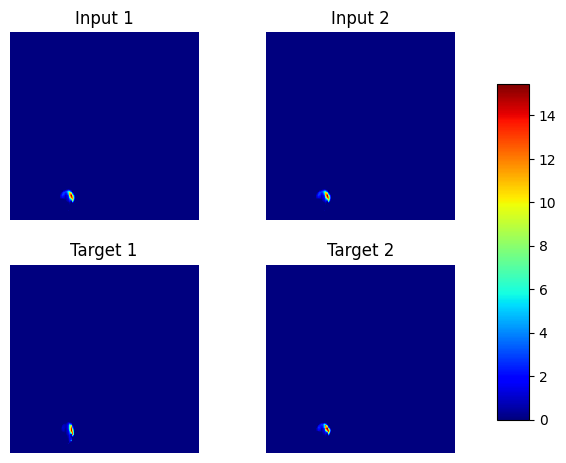

In [55]:
# Test on new distribution

testinputs, testtargets, zdatand = organizedata(dataset,'test/')

no_normalizer = UnitGaussianNormalizer(testinputs[:,0,:,:])
T_normalizer = UnitGaussianNormalizer(testinputs[:,1,:,:])
rad1_normalizer = UnitGaussianNormalizer(testtargets[:,0,:,:])
rad2_normalizer = UnitGaussianNormalizer(testtargets[:,1,:,:])

notest = no_normalizer.encode(testinputs[:,0,:,:])
Ttest = T_normalizer.encode(testinputs[:,1,:,:])
rad1test = rad1_normalizer.encode(testtargets[:,0,:,:])
rad2test = rad2_normalizer.encode(testtargets[:,1,:,:])

getani(testtargets[:,0,:,:], ns, dataset,'radVar1_original',norm=False)
getani(testtargets[:,1,:,:], ns, dataset,'radVar2_original',norm=False)

testinputs = np.stack([notest, Ttest], axis=1)
testtargets = np.stack([rad1test, rad2test], axis=1)
showSbs(testinputs,testtargets,20)

testdata = DfpDataset(testinputs,testtargets)
testLoader  = torch.utils.data.DataLoader(testdata, batch_size=1, shuffle=False, drop_last=True) 

test_results = {"radVar1": np.zeros((ns,nps,nps)),"radVar2": np.zeros((ns,nps,nps))}

net.eval()
L1t_accum = 0.

for i, validata in enumerate(testLoader, 0):
    inputs_curr, targets_curr = validata

    outputs = net(inputs_curr.float().to(device))
    outputs_curr = outputs.data.cpu().numpy()
    o = outputs_curr[0]
    test_results["radVar1"][i,:,:] = rad1_normalizer.decode(o[0,:,:])
    test_results["radVar2"][i,:,:] = rad2_normalizer.decode(o[1,:,:])
    lossL1t = criterionL1(outputs, targets_curr.float().to(device))
    L1t_accum += lossL1t.item()
    #if i%100 ==0: showSbs(targets_curr,outputs_curr,0)

print("\nAverage test error: {}".format( L1t_accum/len(testLoader) ))
# plt.figure()
# plt.imshow(inputs_curr[:,0,:,:].squeeze())
# plt.figure()
# plt.imshow(targets_curr[:,0,:,:].squeeze())
# plt.figure()
# plt.imshow(outputs_curr[0][0,:,:].squeeze())

In [56]:
# denorm_input_vars_nd = getdenorm(zdatand,norm_input_vars_nd,'inputs')
# denorm_target_vars_nd = getdenorm(zdatand,norm_target_vars_nd,'targets')

# denorm_input_vars = getdenorm(zdata,norm_input_vars,'inputs')
# denorm_target_vars = getdenorm(zdata,norm_target_vars,'targets')

# savemat("denorm_input_vars.mat", denorm_input_vars)
# savemat("denorm_target_vars.mat", denorm_target_vars)


In [57]:

# getani(denorm_input_vars['no'], ns, dataset,'no',norm=False)
# getani(denorm_input_vars_nd['no'], ns, dataset,'nond',norm=False)


In [58]:
# denorm_test_vars_nd = getdenorm(zdatand,test_results,'targets')
# savemat("denorm_test_vars.mat", denorm_test_vars_nd)

mean/stddev 907.9638475204176 1650.1227348008154
mean/stddev 6408.259885069141 14431.65869450315


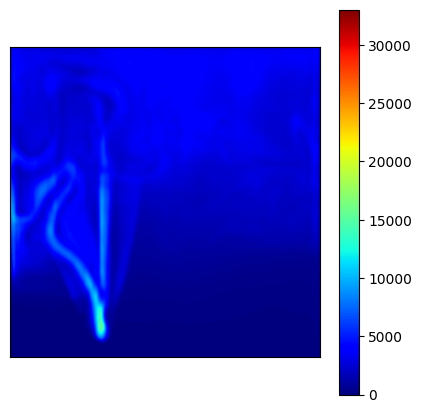

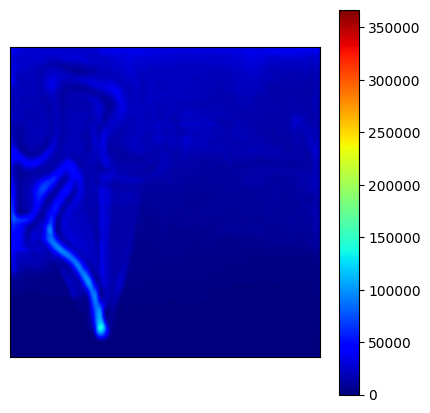

In [59]:
getani(test_results['radVar1'], ns, dataset,'radVar1test',norm=False)
getani(test_results['radVar2'], ns, dataset,'radVar2test',norm=False)


In [60]:
rv1ae = np.zeros((ns,nps,nps))
rv2ae = np.zeros((ns,nps,nps))

for i in range(ns):
    rv1ae[i,:,:] = np.abs(test_results['radVar1'][i,:,:] - testtargets[i,0,:,:])
    rv2ae[i,:,:] = np.abs(test_results['radVar2'][i,:,:] - testtargets[i,0,:,:])
error_dict = {'radVar1': rv1ae, 'radVar2': rv2ae}

# savemat("rv1ae.mat", error_dict['radVar1'])
# savemat("rv2ae.mat", error_dict['radVar2'])

mean/stddev 1063.0889706994176 1554.1636738071497
mean/stddev 8135.274624652987 13532.95918845461


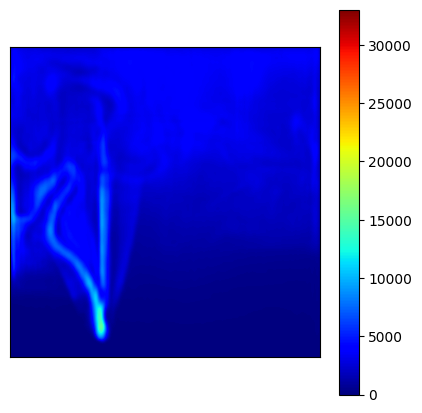

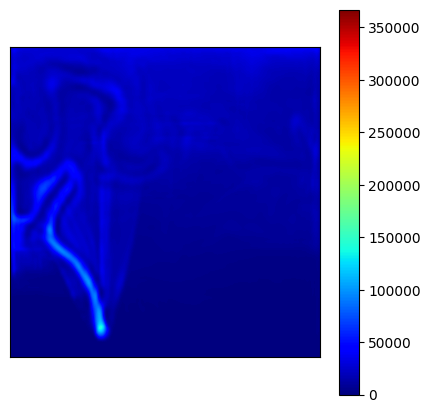

In [61]:


getani(error_dict['radVar1'], ns, dataset,'radVar1error',norm=False)
getani(error_dict['radVar2'], ns, dataset,'radVar2error',norm=False)

